# I. Introduction

This project aims to identify key indicators of heart disease using machine learning techniques. I use a dataset collected from https://www.kaggle.com/datasets/kamilpytlak/personal-key-indicators-of-heart-disease, which includes features like BMI, smoking status, alcohol consumption, physical activity, and more. 

The goal is to train a logistic regression model that can accurately predict the presence of heart disease based on these features. Through this analysis, I hope to uncover the most significant risk factors of heart disease. This understanding can potentially guide medical professionals in early detection and prevention strategies.


In [1]:
import numpy as np
import pandas as pd

from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LogisticRegressionCV
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay

from imblearn.over_sampling import SMOTE


import matplotlib.pyplot as plt

import seaborn as sns
import matplotlib
matplotlib.rcParams['mathtext.fontset'] = 'stix'
matplotlib.rcParams['font.family'] = 'STIXGeneral'
matplotlib.rcParams['font.size'] = 20


# II. Data Processing

In this section, I prepare the dataset for analysis. This involves loading the data, checking for missing and duplicated values, and addressing these issues appropriately. 

The integrity and quality of our data are crucial to the performance of our predictive model. Therefore, I ensure that the dataset is cleaned and well-prepared for further steps of the project.



## 1. Load data
First, I load the data from a CSV file and display the first few rows using the head() function. This gives us an initial look at our data.


In [2]:
df = pd.read_csv('../Project/heart_2020_cleaned.csv')

df.head()


,HeartDisease,BMI,Smoking,AlcoholDrinking,Stroke,PhysicalHealth,MentalHealth,DiffWalking,Sex,AgeCategory,Race,Diabetic,PhysicalActivity,GenHealth,SleepTime,Asthma,KidneyDisease,SkinCancer
0,No,16.60,Yes,No,No,3.0,30.0,No,Female,55-59,White,Yes,Yes,Very good,5.0,Yes,No,Yes
1,No,20.34,No,No,Yes,0.0,0.0,No,Female,80 or older,White,No,Yes,Very good,7.0,No,No,No
2,No,26.58,Yes,No,No,20.0,30.0,No,Male,65-69,White,Yes,Yes,Fair,8.0,Yes,No,No
3,No,24.21,No,No,No,0.0,0.0,No,Female,75-79,White,No,No,Good,6.0,No,No,Yes
4,No,23.71,No,No,No,28.0,0.0,Yes,Female,40-44,White,No,Yes,Very good,8.0,No,No,No




## 2. check for missing value


In [18]:
df.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 301717 entries, 0 to 319794
Data columns (total 40 columns):
 #   Column                               Non-Null Count   Dtype  
---  ------                               --------------   -----  
 0   HeartDisease                         301717 non-null  int64  
 1   BMI                                  301717 non-null  int64  
 2   Smoking                              301717 non-null  int64  
 3   AlcoholDrinking                      301717 non-null  int64  
 4   Stroke                               301717 non-null  int64  
 5   PhysicalHealth                       301717 non-null  float64
 6   MentalHealth                         301717 non-null  float64
 7   DiffWalking                          301717 non-null  int64  
 8   Sex                                  301717 non-null  int64  
 9   PhysicalActivity                     301717 non-null  int64  
 10  SleepTime                            301717 non-null  float64
 11  Asthma       

### Conclusion: The dataset has no missing value

## 3. check for duplicated value

The dataset has 18078 duplicated value. I drop all duplicated value.


In [4]:
df.duplicated().sum()


18078

In [5]:
df.drop_duplicates(inplace=True)
df.duplicated().sum()


0

## III. Exploratory Data Analysis (EDA)

Exploratory Data Analysis is an essential step in understanding the dataset. 

In this section, I conduct exploratory data analysis to understand the distributions, relationships, and correlations among the variables in the dataset. This information is crucial in guiding my subsequent feature engineering and model training steps.


## 1. statistical summary
First, I use the describe(\) function to get a statistical summary of the data, including count, mean, standard deviation, minimum, and maximum values. I also check again for missing values.


In [6]:
# Get a summary of the data
summary = df.describe(include='all')

# Check for missing values
missing_values = df.isnull().sum()

summary, missing_values


(       HeartDisease            BMI Smoking AlcoholDrinking  Stroke  \
 count        301717  301717.000000  301717          301717  301717   
 unique            2            NaN       2               2       2   
 top              No            NaN      No              No      No   
 freq         274456            NaN  174312          280136  289653   
 mean            NaN      28.441970     NaN             NaN     NaN   
 std             NaN       6.468134     NaN             NaN     NaN   
 min             NaN      12.020000     NaN             NaN     NaN   
 25%             NaN      24.030000     NaN             NaN     NaN   
 50%             NaN      27.410000     NaN             NaN     NaN   
 75%             NaN      31.650000     NaN             NaN     NaN   
 max             NaN      94.850000     NaN             NaN     NaN   
 
         PhysicalHealth   MentalHealth DiffWalking     Sex AgeCategory    Race  \
 count    301717.000000  301717.000000      301717  301717      

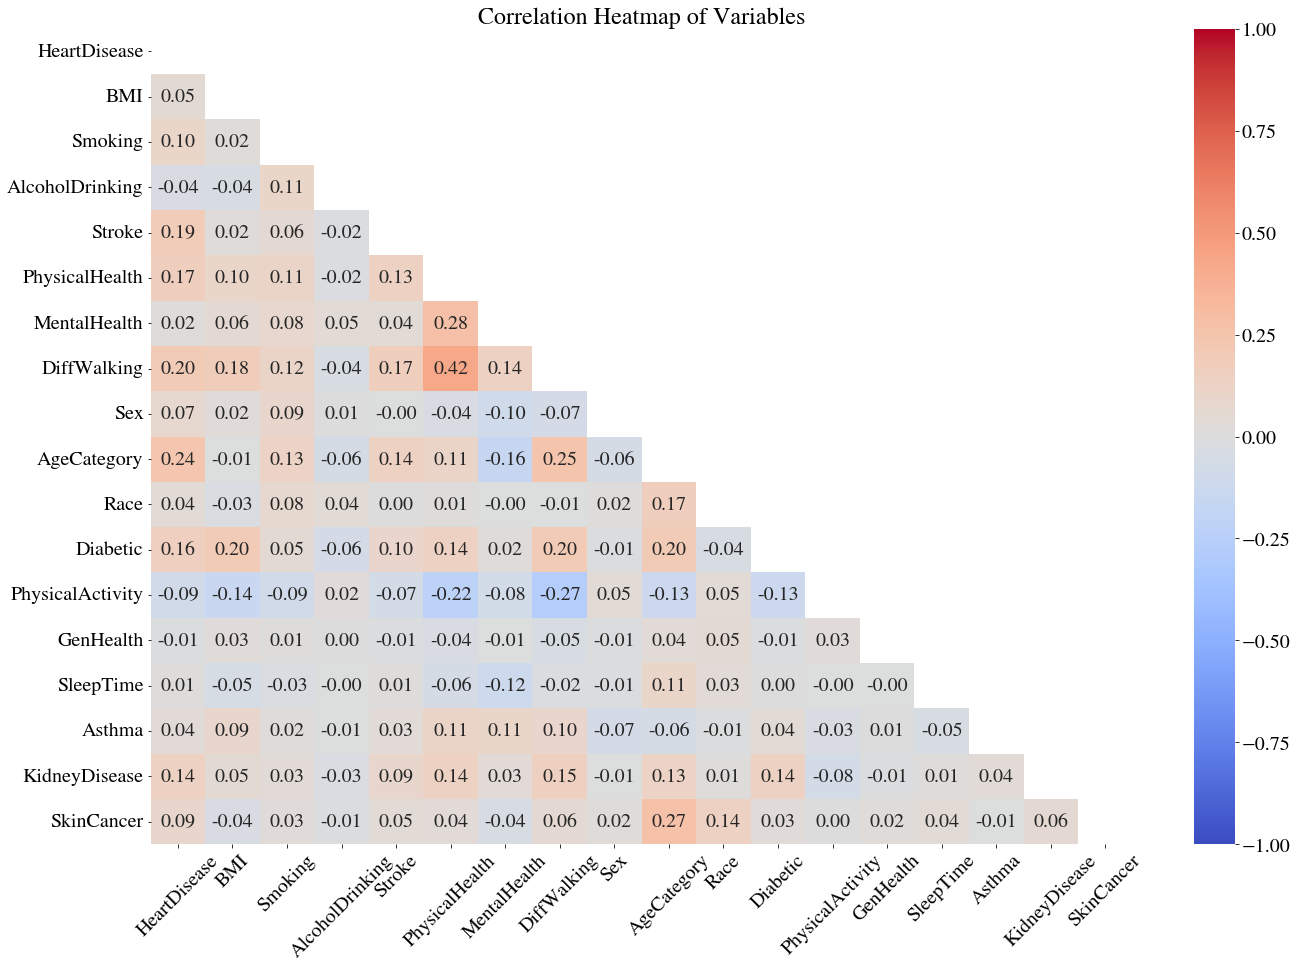

In [7]:
# Convert categorical variables to numeric for correlation calculation
df_for_corr = df.copy()
for column in df_for_corr.columns:
    if df_for_corr[column].dtype == 'object' and column != 'HeartDisease':
        df_for_corr[column] = df_for_corr[column].astype('category').cat.codes

# Convert HeartDisease to binary
df_for_corr['HeartDisease'] = df_for_corr['HeartDisease'].map({'Yes': 1, 'No': 0})

# Calculate correlations
correlations = df_for_corr.corr()

# Create a mask to only show the lower triangle of the matrix 
mask = np.triu(np.ones_like(correlations, dtype=bool))

# Plot the heatmap
plt.figure(figsize=(22, 15))
sns.heatmap(correlations, mask=mask, cmap='coolwarm', vmax=1, vmin=-1, center=0, annot=True, fmt=".2f")
plt.title('Correlation Heatmap of Variables')
plt.xticks(rotation=45)
plt.show()

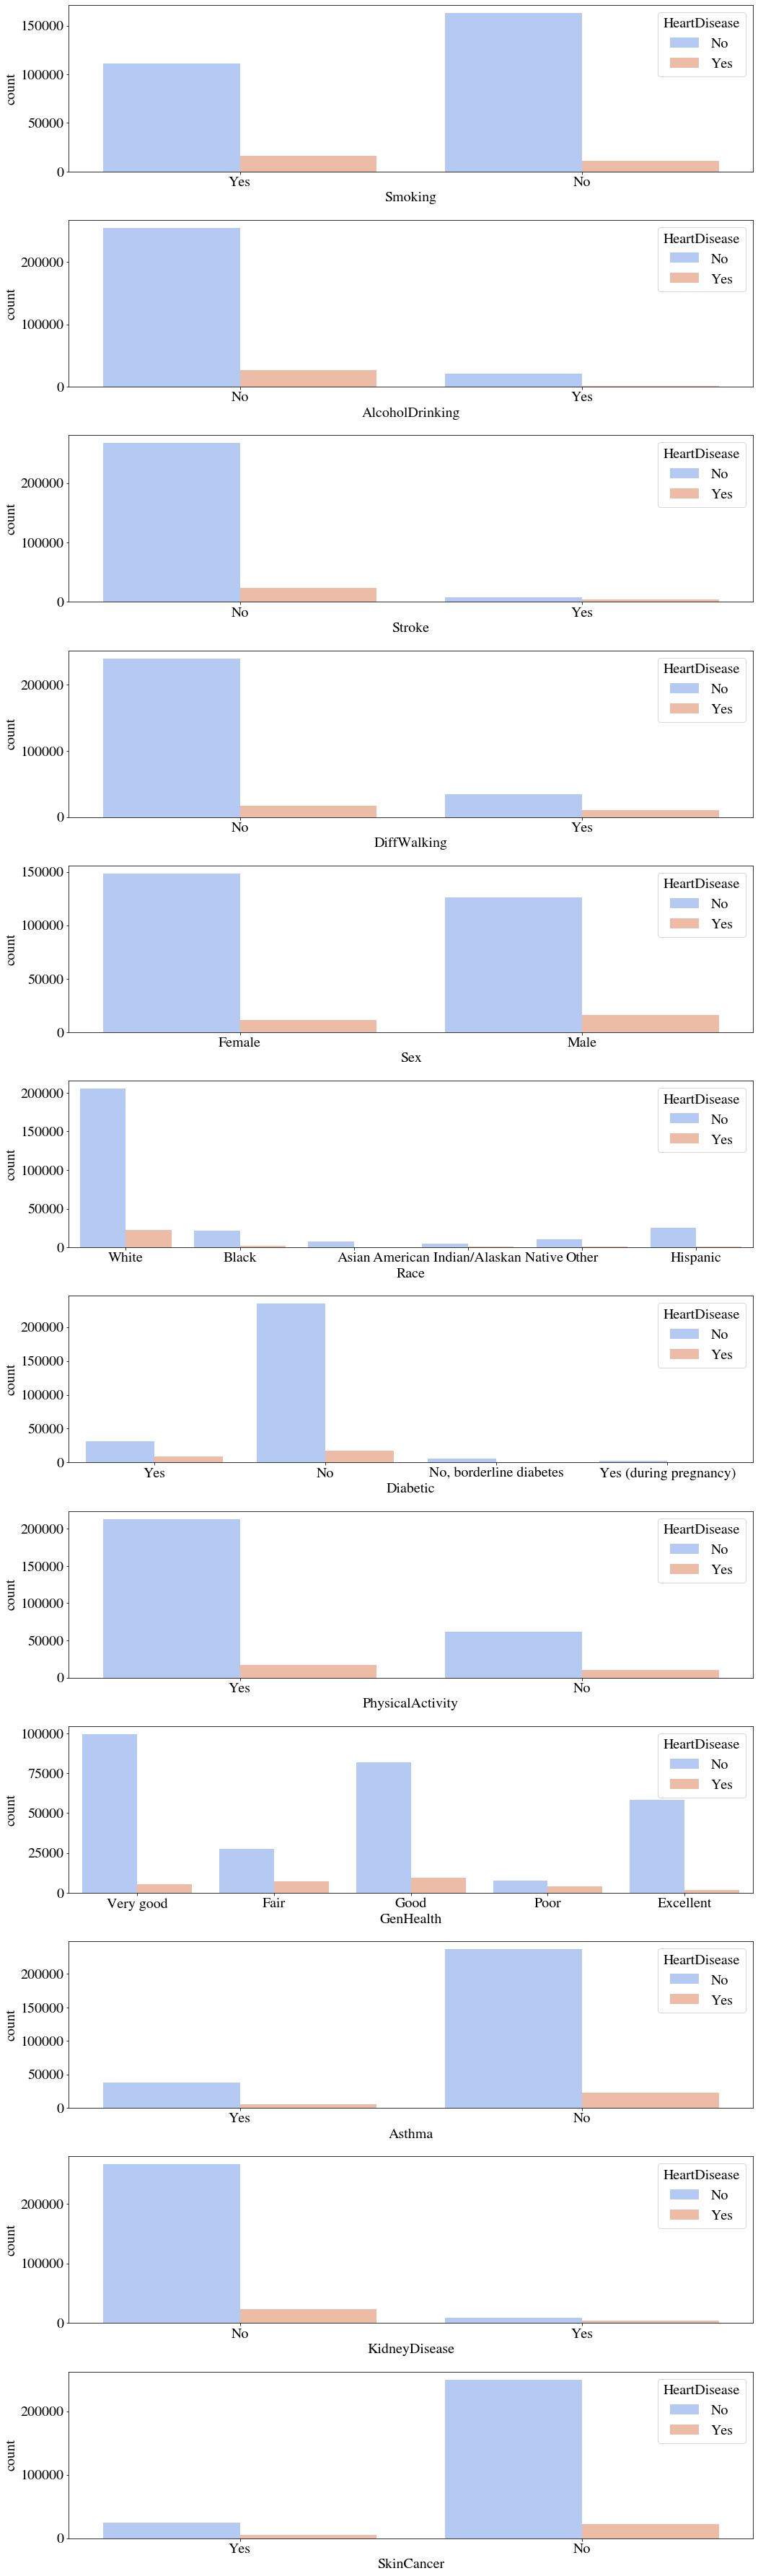

In [8]:
# Plotting the distribution of HeartDisease with respect to several categorical variables

categorical_vars = ['Smoking', 'AlcoholDrinking', 'Stroke', 'DiffWalking', 'Sex', 'Race', 'Diabetic', 'PhysicalActivity', 'GenHealth', 'Asthma', 'KidneyDisease', 'SkinCancer']

fig, axs = plt.subplots(nrows=len(categorical_vars), figsize=(15, 50))

for i, var in enumerate(categorical_vars):
    sns.countplot(x=var, hue='HeartDisease', data=df, ax=axs[i], palette='coolwarm')

plt.tight_layout()
plt.show()

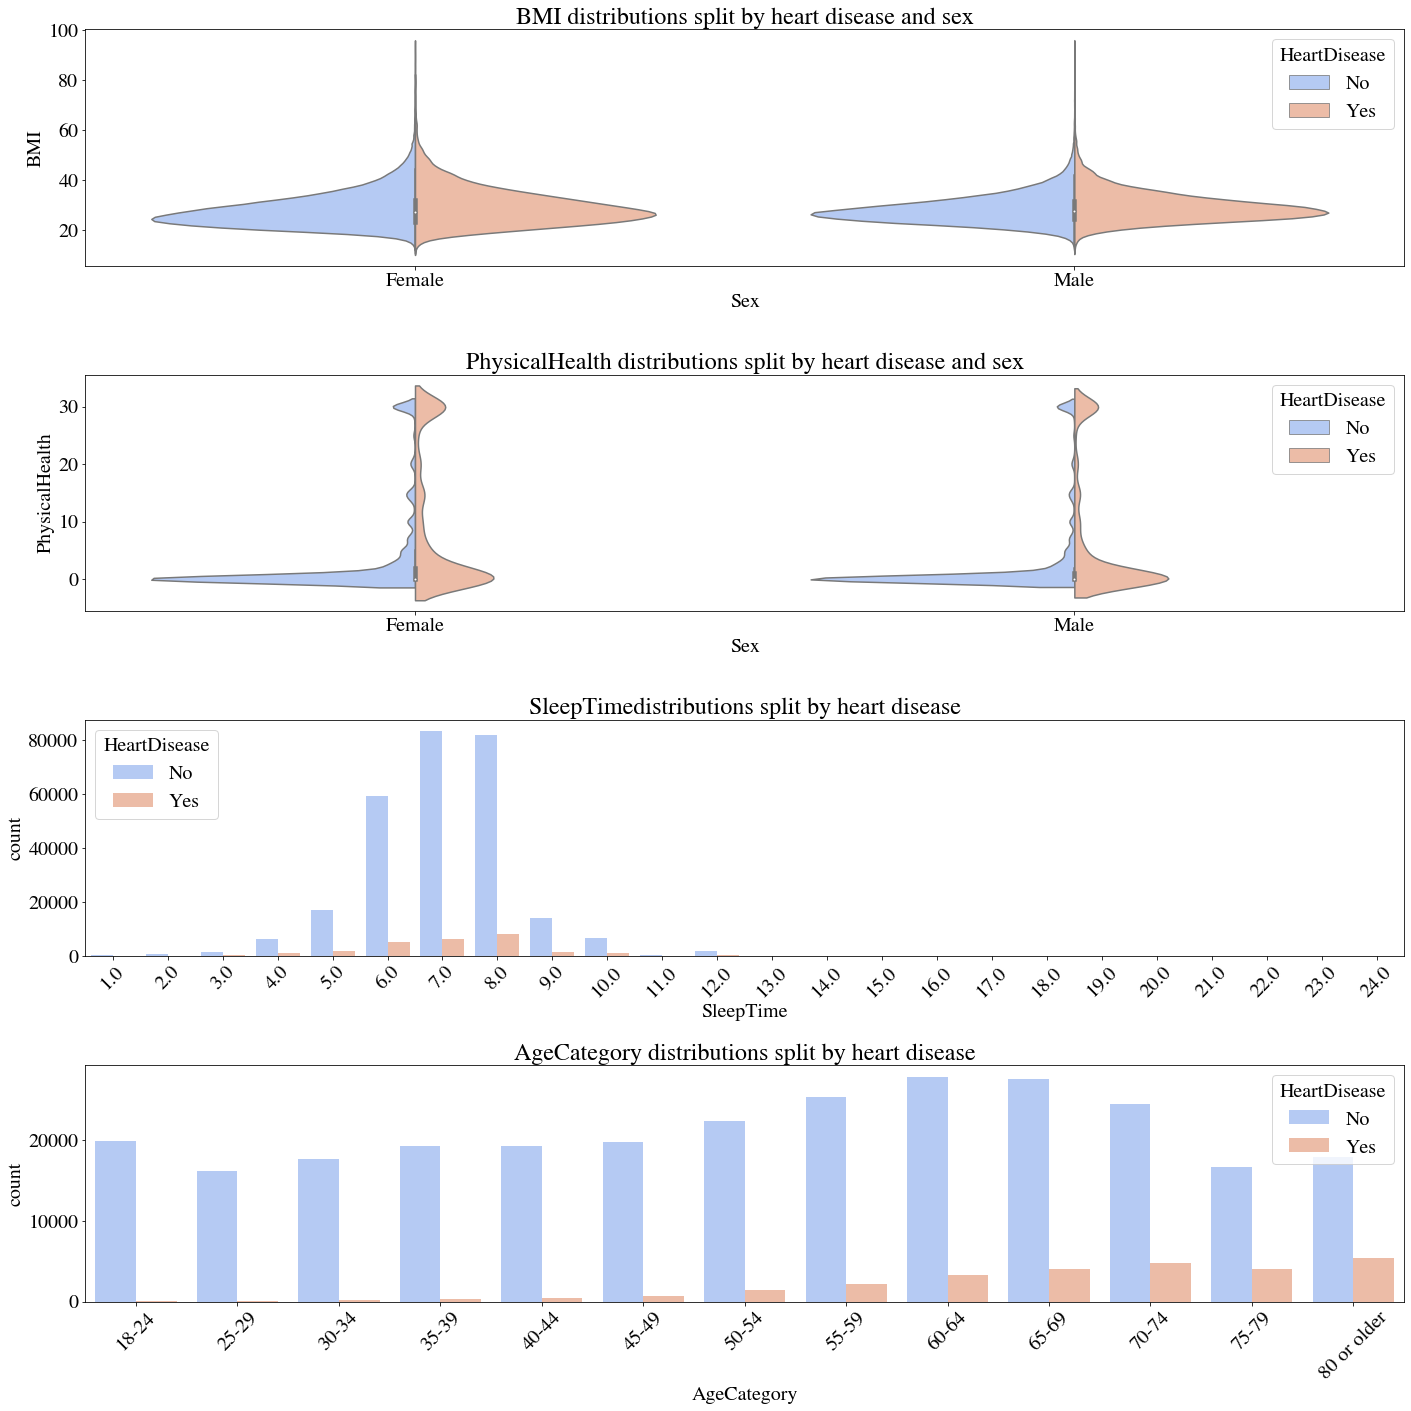

In [9]:
# Define the figure size
plt.figure(figsize=(20, 20))

# 1. BMI distributions split by heart disease and sex
plt.subplot(4, 1, 1)
sns.violinplot(x='Sex', y='BMI', hue='HeartDisease', data=df, split=True, palette='coolwarm')
plt.title('BMI distributions split by heart disease and sex')

# 2. PhysicalHealth distributions split by heart disease and sex
plt.subplot(4, 1, 2)
sns.violinplot(x='Sex', y='PhysicalHealth', hue='HeartDisease', data=df, split=True, palette='coolwarm')
plt.title('PhysicalHealth distributions split by heart disease and sex')

# 3. SleepTime distributions split by heart disease and sex
plt.subplot(4, 1, 3)
sns.countplot(x='SleepTime', hue='HeartDisease', data=df, palette='coolwarm', order=sorted(df['SleepTime'].unique()))
plt.title('SleepTimedistributions split by heart disease')
plt.xticks(rotation=45)


# 4. AgeCategory distributions split by heart disease and diabetic status
plt.subplot(4, 1, 4)
sns.countplot(x='AgeCategory', hue='HeartDisease', data=df, palette='coolwarm', order=sorted(df['AgeCategory'].unique()))
plt.title('AgeCategory distributions split by heart disease')
plt.xticks(rotation=45)

# Show the plot
plt.tight_layout()
plt.show()


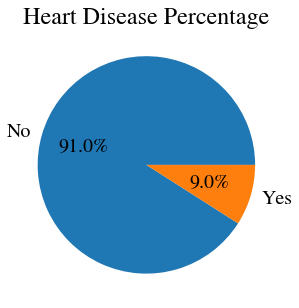

In [10]:
plt.figure(figsize=(5, 5))

plt.pie(x = df['HeartDisease'].value_counts() ,autopct='%1.1f%%' ,labels=['No', 'Yes'])
plt.title('Heart Disease Percentage')
plt.show()

### Note: the data is imbalanced

# IV. Feature Engineering and Selection


Based on our understanding from the EDA, we engineer and select features that we believe will be most informative for our model. This includes binning the BMI based on the WHO classification and transforming categorical values to numerical values.

We also use a Random Forest classifier to rank the importance of features and select the most important ones. This step ensures that our model focuses on the most relevant information and simplifies the complexity of the model.


### 1. Bin the BMI based on the WHO classification


In [11]:
# Define a function to bin the BMI based on the WHO classification
# <18.5: Underweight; 18.5–25: Normal weight, 25-30: Pre-obesity, > 30: Obesity
def bin_bmi(bmi):
    if bmi < 18.5:
        return 0
    elif 18.5 <= bmi < 25:
        return 1
    elif 25 <= bmi < 30:
        return 2
    else:  # bmi >= 30
        return 3

# Apply the function to the 'BMI' column
df['BMI'] = df['BMI'].apply(bin_bmi)



### 2. Transform categorical value to numerical value ( 0 or 1)

In [12]:
# Initialize label encoder
le = LabelEncoder()

# List of binary columns to label encode
binary_columns = [col for col in df.columns if df[col].nunique() == 2]

# Label encode binary columns
for col in binary_columns:
    df[col] = le.fit_transform(df[col])

# One-hot encode the remaining categorical columns
df = pd.get_dummies(df)

df.head()

,HeartDisease,BMI,Smoking,AlcoholDrinking,Stroke,PhysicalHealth,MentalHealth,DiffWalking,Sex,PhysicalActivity,...,Race_White,Diabetic_No,"Diabetic_No, borderline diabetes",Diabetic_Yes,Diabetic_Yes (during pregnancy),GenHealth_Excellent,GenHealth_Fair,GenHealth_Good,GenHealth_Poor,GenHealth_Very good
0,0,0,1,0,0,3.0,30.0,0,0,1,...,1,0,0,1,0,0,0,0,0,1
1,0,1,0,0,1,0.0,0.0,0,0,1,...,1,1,0,0,0,0,0,0,0,1
2,0,2,1,0,0,20.0,30.0,0,1,1,...,1,0,0,1,0,0,1,0,0,0
3,0,1,0,0,0,0.0,0.0,0,0,0,...,1,1,0,0,0,0,0,1,0,0
4,0,1,0,0,0,28.0,0.0,1,0,1,...,1,1,0,0,0,0,0,0,0,1




### 3. Use ramdom forest to do features selection and feature engineering


In [13]:

# Split the dataset into features (X) and the target variable (y)
X = df.drop('HeartDisease', axis=1)
y = df['HeartDisease']

# Initialize a Random Forest classifier
rf = RandomForestClassifier(n_estimators=100, random_state=42)

# Fit the classifier to the entire dataset
rf.fit(X, y)

# Get feature importances
importances = rf.feature_importances_

# Create a dataframe for visualization
importances_df = pd.DataFrame({'Feature': X.columns, 'Importance': importances})

# Sort the dataframe by importance in descending order
importances_df = importances_df.sort_values('Importance', ascending=False)

# Compute the mean feature importance
threshold = 0.001 #importances_df['Importance'].median()

# Select features where importance is greater than or equal to the threshold
selected_features = importances_df[importances_df['Importance'] >= threshold]['Feature']

importances_df,selected_features



(                                Feature  Importance
 9                             SleepTime    0.174269
 4                        PhysicalHealth    0.122894
 5                          MentalHealth    0.104311
 0                                   BMI    0.085680
 8                      PhysicalActivity    0.039631
 3                                Stroke    0.034395
 10                               Asthma    0.031843
 6                           DiffWalking    0.030972
 7                                   Sex    0.030403
 1                               Smoking    0.028611
 12                           SkinCancer    0.023508
 25              AgeCategory_80 or older    0.021405
 11                        KidneyDisease    0.019885
 39                       GenHealth_Poor    0.017771
 34                         Diabetic_Yes    0.017070
 37                       GenHealth_Fair    0.015355
 31                           Race_White    0.015163
 24                    AgeCategory_75-79    0.

In [14]:
df['AgeCategory_under 35'] = df['AgeCategory_18-24'] + df['AgeCategory_25-29'] + df['AgeCategory_30-34']
df = df.drop(['AgeCategory_18-24', 'AgeCategory_25-29','AgeCategory_30-34'], axis=1)


In [15]:

# Split the dataset into features (X) and the target variable (y)
X = df.drop('HeartDisease', axis=1)
y = df['HeartDisease']

# Initialize a Random Forest classifier
rf = RandomForestClassifier(n_estimators=100, random_state=42)

# Fit the classifier to the entire dataset
rf.fit(X, y)

# Get feature importances
importances = rf.feature_importances_

# Create a dataframe for visualization
importances_df = pd.DataFrame({'Feature': X.columns, 'Importance': importances})

# Sort the dataframe by importance in descending order
importances_df = importances_df.sort_values('Importance', ascending=False)

# Compute the mean feature importance
threshold = 0.001 #importances_df['Importance'].median()

# Select features where importance is greater than or equal to the threshold
selected_features = importances_df[importances_df['Importance'] >= threshold]['Feature']

importances_df,selected_features



(                                Feature  Importance
 9                             SleepTime    0.173686
 4                        PhysicalHealth    0.121542
 5                          MentalHealth    0.105999
 0                                   BMI    0.085689
 8                      PhysicalActivity    0.038772
 3                                Stroke    0.033588
 10                               Asthma    0.031715
 6                           DiffWalking    0.031614
 1                               Smoking    0.029901
 7                                   Sex    0.027881
 12                           SkinCancer    0.023211
 22              AgeCategory_80 or older    0.020151
 11                        KidneyDisease    0.019822
 31                         Diabetic_Yes    0.018144
 36                       GenHealth_Poor    0.017852
 34                       GenHealth_Fair    0.015264
 28                           Race_White    0.015184
 20                    AgeCategory_70-74    0.

# V. Model Training

I chose the Logistic Regression model due to its simplicity and interpretability. Before training, I addressed the class imbalance in our dataset using the SMOTE technique, as imbalanced data could bias our model towards the majority class. 

After training the model, I evaluated its performance using several metrics, including accuracy and the confusion matrix. These metrics give us a comprehensive view of how well our model performs in predicting heart disease.


## 1. Address the imbalance of dataset

Previoulsy, we see the the majority of the dataset contains people who do not have heart disease. To better train the classification algorithm, I need to oversample the dataset so that the training set contains 50% of people who have heart disease, and 50% of people who do not have heart disease.

0    274456
1    274456
Name: HeartDisease, dtype: int64


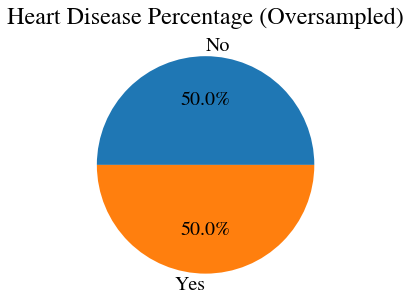

In [16]:

# Oversample the dataset
smote = SMOTE(k_neighbors=50, random_state=42)
X_smoted, y_smoted = smote.fit_resample(X, y)

# Split the data into 80% for training and 20% for testing
X_train, X_test, y_train, y_test = train_test_split(X_smoted, y_smoted, test_size=0.2, random_state=42)

# Perform feature scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print(y_smoted.value_counts())

plt.figure(figsize=(5, 5))
plt.pie(x = y_smoted.value_counts() ,autopct='%1.1f%%' ,labels=['No', 'Yes'])
plt.title('Heart Disease Percentage (Oversampled)')
plt.show()

### 2. Train logistic model

Train Accuracy: 86.54564%
Test Accuracy: 86.54436%


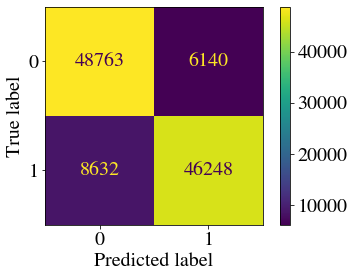

              precision    recall  f1-score   support

           0       0.85      0.89      0.87     54903
           1       0.88      0.84      0.86     54880

    accuracy                           0.87    109783
   macro avg       0.87      0.87      0.87    109783
weighted avg       0.87      0.87      0.87    109783



In [17]:


# Create and train the logistic regression model with cross-validation
lr = LogisticRegressionCV(cv=4)  # Specify the number of cross-validation folds (5 in this case)
lr.fit(X_train_scaled, y_train)

# Predict using the trained model
y_pred = lr.predict(X_test_scaled)

# Calculate the train accuracy of the classifier
tr_accuracy = lr.score(X_train_scaled, y_train)

# Calculate the accuracy of the classifier
ts_accuracy = accuracy_score(y_test, y_pred)

print("Train Accuracy:", f'{round(tr_accuracy * 100, 5)}%')
print("Test Accuracy:", f'{round(ts_accuracy * 100, 5)}%')

# Confusion matrix
c_matrix = confusion_matrix(y_test, y_pred)
cm_display = ConfusionMatrixDisplay(confusion_matrix = c_matrix)
cm_display.plot()
plt.show()

# Classification report
print(classification_report(y_test, y_pred, digits=2))

# Conclusion

In this project, I analyzed a heart disease dataset and built a logistic regression model to identify key indicators of heart disease. We found that Sleep time is the top indicator of heart disease. 

While the model's current performance is with 0.87 recall and precision rates, with further fine-tuning and potentially more data, this model could be a useful tool for medical professionals to predict heart disease based on a patient's lifestyle and health status.
